In [7]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to the JSON files
file_paths = [
    r"C:\Users\PC\Downloads\llama_files\llama_events_tf_results_0_9000.json",
    r"C:\Users\PC\Downloads\llama_files\llama_events_tf_results_9001_19818.json"
]

# Define keywords for location and year questions for each language
location_keywords = {
    'EN': ["took place in"],
    'FR': [" a eu lieu en"],
    'DE': ["fand in "],
    'TR': ["ülkesinde gerçekleşti"],
    'JA': ["で行われました"]
}

year_keywords = {
    'EN': ["occurred in"],
    'FR': ["quelle année a eu lieu l'événement"],
    'DE': ["fand im Jahr"],
    'TR': ["yılında gerçekleşti"],
    'JA': ["年に行われました。"]
}

# Function to load JSON file and convert to DataFrame
def load_json_to_df(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

# Function to classify question type based on keywords
def get_question_type(question, language, index, total):
    if language not in location_keywords or language not in year_keywords:
        return "Other"
    
    # Specific handling for French to split equally
    if language == 'FR':
        # If total French questions are even, split equally
        # If odd, the extra will be classified as Location
        mid_point = total // 2
        if index < mid_point:
            return "Location"
        else:
            return "Year"
    
    for keyword in location_keywords[language]:
        if keyword.lower() in question.lower():
            return "Location"
    for keyword in year_keywords[language]:
        if keyword.lower() in question.lower():
            return "Year"
    return "Other"

# Initialize a DataFrame to store combined data
combined_df = pd.DataFrame()

# Load data from the JSON files
for file_path in file_paths:
    df = load_json_to_df(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Count the total number of French questions
total_french = combined_df[combined_df['Language'] == 'FR'].shape[0]

# Apply the question type classification
def classify_row(row):
    if row['Language'] == 'FR':
        index = row.name % total_french  # Use the row index within French rows
        return get_question_type(row['Question'], row['Language'], index, total_french)
    else:
        return get_question_type(row['Question'], row['Language'], None, None)

combined_df['question_type'] = combined_df.apply(classify_row, axis=1)



In [8]:
combined_df

,Question,Model_Answer,Actual_Answer,Compared_Answer,Language,Time_Taken,question_type
0,The event 'Battle of White Oak Swamp' took pla...,(True or False) True False\nThe event,False,1,EN,1.738499,Location
1,The event 'Battle of White Oak Swamp' occurred...,0.0.0.0.0.,False,0,EN,0.626665,Year
2,The event 'Battle of Springfield' took place i...,FALSE. The event 'Battle of Springfield' did,False,1,EN,0.624977,Location
3,The event 'Battle of Springfield' occurred in ...,False\n* 4. The event 'Battle,False,1,EN,0.625561,Year
4,The event 'Battle of la Truyère' took place in...,FALSE The Battle of la Truyère was a battle,False,1,EN,0.626111,Location
...,...,...,...,...,...,...,...
19812,イベント'Battle of Gilgal Church'は1919.0年に行われました。,(True or False) \n* 1919,False,1,JA,0.625480,Year
19813,イベント'エリザベス1世の戴冠式'はフランスで行われました。,→ 偽 イベント'ウィンザー,False,1,JA,0.625692,Location
19814,イベント'エリザベス1世の戴冠式'は1591.0年に行われました。,(真/偽) → 偽,False,1,JA,0.625221,Year
19815,イベント'Battle of South Mills'はアメリカ合衆国で行われました。,真偽\n\n（参考：Battle of,True,1,JA,0.625363,Location


In [9]:
combined_df.to_csv('tf_events_llama.csv', index=False)

In [91]:
#filtered_df = dfs['French People'][dfs['English People']['Language'] == 'TR'].head(50)
#print(filtered_df)

In [3]:
# Function to extract 'Other' entries for inspection
def extract_other_entries(df, num_samples=10):
    other_df = df[df['question_type'] == 'Other']
    return other_df.sample(min(num_samples, len(other_df)), random_state=1)

# Extract 'Other' entries for inspection
other_entries = extract_other_entries(combined_df)

# Display the 'Other' entries
print("Entries classified as 'Other':")
print(other_entries)

# Display summary statistics by language
summary = combined_df.groupby(['Language', 'question_type']).size().unstack(fill_value=0)
print("Summary statistics by language:")
print(summary)

Entries classified as 'Other':
Empty DataFrame
Columns: [Question, Model_Answer, Actual_Answer, Compared_Answer, Language, Time_Taken, question_type]
Index: []
Summary statistics by language:
question_type  Location  Year
Language                     
DE                 1984  1985
EN                 1972  1972
FR                 1997  1997
JA                 1983  1983
TR                 1972  1972


In [4]:
# Function to populate most common values DataFrame
def populate_most_common_combined(df):
    most_common_df = pd.DataFrame(columns=['Column Name', 'Column Type', 'Most Common Values', 'Counts', 'Unique Values'])
    for column in df.columns:
        most_common_values = df[column].value_counts().nlargest(5).index.tolist()
        counts = df[column].value_counts().nlargest(5).tolist()
        column_type = df[column].dtype
        unique_values = df[column].nunique()

        row = {
            'Column Name': column,
            'Column Type': column_type,
            'Most Common Values': most_common_values,
            'Counts': counts,
            'Unique Values': unique_values
        }
        
        most_common_df = pd.concat([most_common_df, pd.DataFrame([row])], ignore_index=True)
    return most_common_df

# Initialize dictionaries to store DataFrames for each language group
language_groups = combined_df['Language'].unique()
most_common_values_dfs = {lang: None for lang in language_groups}

# Populate most common values DataFrames for each language group
for lang in language_groups:
    df_lang = combined_df[combined_df['Language'] == lang]
    most_common_values_dfs[lang] = populate_most_common_combined(df_lang)

# Display the updated DataFrames for each language group
for lang, most_common_values_df in most_common_values_dfs.items():
    print(f"Most common values for {lang}:")
    print(most_common_values_df.to_string(index=False))
    print("\n")

Most common values for EN:
    Column Name Column Type                                                                                                                                                                                                                                                                                               Most Common Values                Counts Unique Values
       Question      object [The event 'Battle of Toulouse' took place in France., The event 'Battle of Aizenay' took place in France., The event 'Battle of San Juan' took place in United States of America., The event 'Battle of Martinique' took place in United States of America., The event 'Battle of Arras' took place in France.]       [3, 2, 2, 2, 2]          3917
   Model_Answer      object                                                                                                                                       [0.0.0.0.0., True or False? False. The event 'Battle, True or False? \n\n

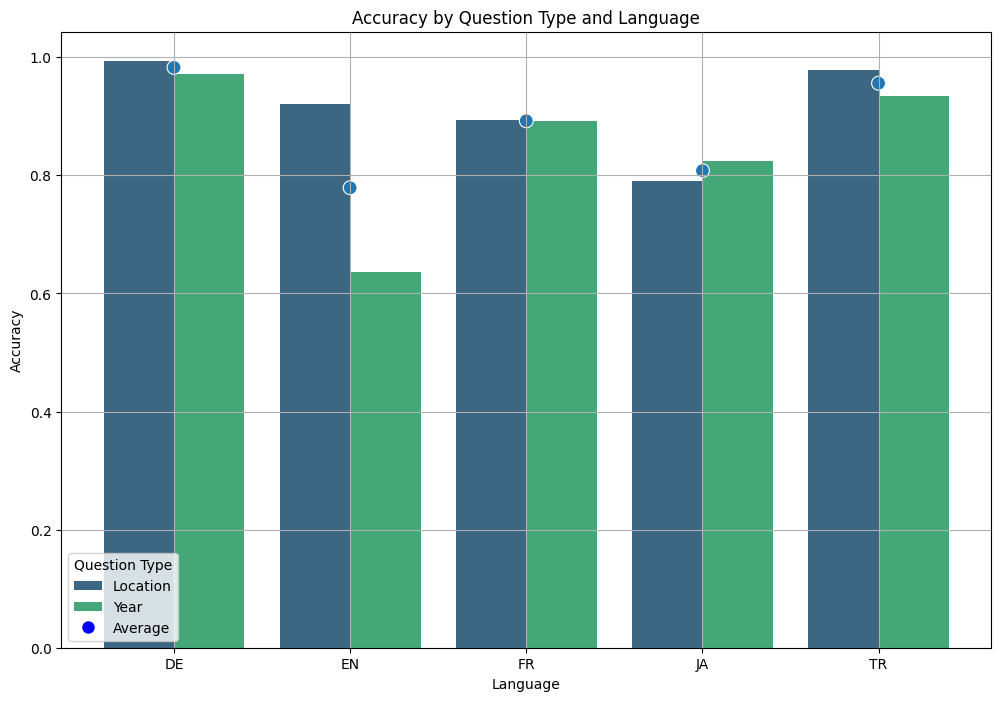

In [5]:
# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['Language', 'question_type'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Location', 'Year'])]

# Calculate the average accuracy for each language
average_accuracy_df = filtered_accuracy_df.groupby('Language')['Accuracy'].mean().reset_index()
average_accuracy_df['question_type'] = 'Average'

# Combine the average accuracy with the filtered accuracy data
combined_accuracy_df = pd.concat([filtered_accuracy_df, average_accuracy_df], ignore_index=True)

# Plot the accuracies
plt.figure(figsize=(12, 8))

# Bar plot for Location and Year questions
sns.barplot(x='Language', y='Accuracy', hue='question_type', data=filtered_accuracy_df, palette='viridis')

# Scatter plot for Average accuracy
sns.scatterplot(x='Language', y='Accuracy', hue='question_type', style='question_type', data=average_accuracy_df, markers=['o'], s=100, color='blue', legend=False)

# Add a custom legend for the average dots
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Average', markersize=10, markerfacecolor='blue'))
labels.append('Average')

plt.legend(handles=handles, title='Question Type')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by Question Type and Language')
plt.grid(True)
plt.show()

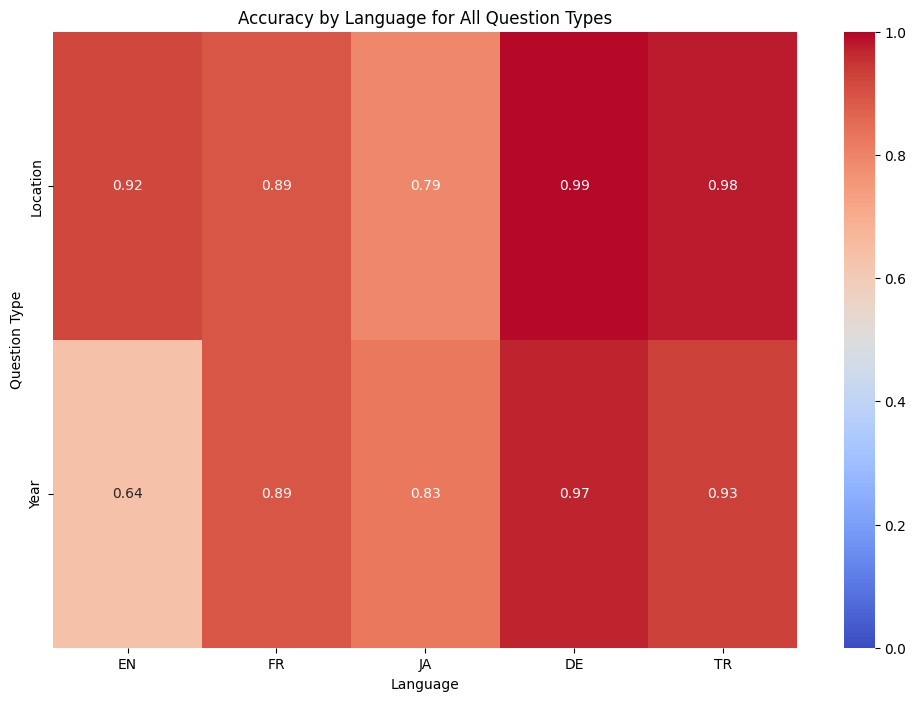

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order for groups and languages
language_order = ['EN', 'FR', 'JA', 'DE', 'TR']

# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['question_type', 'Language'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Location', 'Year'])]

# Create a pivot table for the heat map
pivot_df = filtered_accuracy_df.pivot_table(index='question_type', columns='Language', values='Accuracy')

# Reorder the languages in the pivot table
pivot_df = pivot_df[language_order]

# Plot a combined heatmap for all question types
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.xlabel('Language')
plt.ylabel('Question Type')
plt.title('Accuracy by Language for All Question Types')
plt.show()
